In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.impute import SimpleImputer
import numpy as np

In [2]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [4]:
def timeCorrection(dataframe):
    startTime = list(dataframe.loc[:,"start_time"])
    endTime = list(dataframe.loc[:,"end_time"])
    isoFormatS = []
    isoFormatE = []
    for i in range(0,len(startTime)):
        if len(startTime[i]) < 19:
            d1 = datetime.strptime(startTime[i], '%m/%d/%Y %H:%M')
            d2 = datetime.strptime(endTime[i], '%m/%d/%Y %H:%M')
            isoFormatS.append(d1.isoformat())
            isoFormatE.append(d2.isoformat())
        else:
            isoFormatS.append(startTime[i])
            isoFormatE.append(endTime[i])
    dataframe["start_time"] = isoFormatS
    dataframe["end_time"] = isoFormatE
    dataframe['start_time'] = pd.to_datetime(dataframe['start_time'], errors='coerce')
    dataframe['end_time'] = pd.to_datetime(dataframe["end_time"], errors='coerce')
    dataframe["start_time"] = dataframe["start_time"].dt.round("H")
    dataframe["end_time"] = dataframe["end_time"].dt.round("H")  
    startHR = list(map(str,dataframe["start_time"]))
    endHR = list(map(str,dataframe["end_time"]))
    endhr = []
    starthr = []
    for hr in range(0, len(startHR)):
        starthr.append(startHR[hr][11:])
        endhr.append(endHR[hr][11:])
    
    dataframe["hr_start_time"] = starthr
    dataframe["hr_end_time"] = endhr
    
    return dataframe


In [5]:
df = pd.read_csv("./ds-programming-test/train_set.csv")

C:\Users\Rafa\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.head(5)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443


In [7]:
print("Número de bicicletas con las que dispone el servicio: {}".format(len(df["bike_id"].unique())))

Número de bicicletas con las que dispone el servicio: 7563


In [8]:
df.describe()

,trip_id,duration,start_lat,start_lon,end_lat,end_lon,plan_duration,start_station,end_station
count,7.000000e+05,700000.000000,694437.000000,694437.000000,681426.000000,681426.000000,699792.000000,700000.000000,700000.000000
mean,1.069468e+08,37.084979,34.044952,-118.253849,34.044175,-118.259183,44.928697,3499.720464,3489.726771
std,4.497342e+07,125.302510,0.325255,2.332640,0.299721,2.129781,92.816296,615.918795,613.040769
min,8.369648e+06,1.000000,33.710979,-118.495422,33.710979,-118.495422,0.000000,3000.000000,3000.000000
25%,7.538051e+07,7.000000,34.037460,-118.280952,34.037048,-118.280952,1.000000,3031.000000,3030.000000
50%,1.179410e+08,13.000000,34.046612,-118.256980,34.046520,-118.256981,30.000000,3064.000000,3064.000000
75%,1.404178e+08,26.000000,34.051941,-118.247162,34.050911,-118.246422,30.000000,4214.000000,4214.000000
max,1.794831e+08,1440.000000,55.705528,118.238258,55.705528,37.606541,999.000000,4594.000000,4594.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 74.8+ MB


In [18]:
df = timeCorrection(df)

In [19]:
df.head(5)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,hr_start_time,hr_end_time
0,101750280,35,2018-08-07 11:00:00,2018-08-07 12:00:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127,11:00:00,12:00:00
1,46560345,32,2017-09-17 18:00:00,2017-09-17 18:00:00,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062,18:00:00,18:00:00
2,120016336,6,2019-04-22 09:00:00,2019-04-22 09:00:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062,09:00:00,09:00:00
3,129547190,138,2019-09-22 11:00:00,2019-09-22 14:00:00,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311,11:00:00,14:00:00
4,136619463,14,2020-01-31 17:00:00,2020-01-31 17:00:00,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443,17:00:00,17:00:00


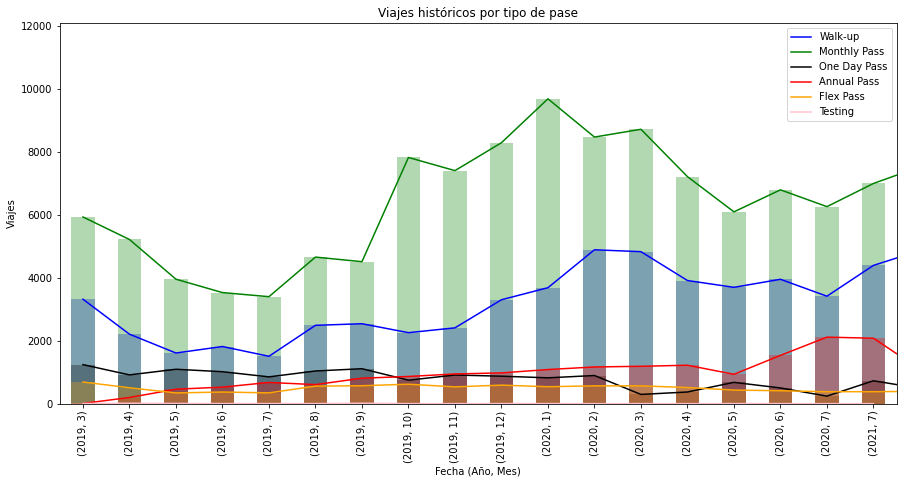

In [20]:
passholderTypes = list(df.loc[df["passholder_type"].notna(), "passholder_type"].unique())
fig = plt.figure(figsize =(15, 7))    

colors =["blue", "green", "black", "red", "orange", "pink"]
i = 0
hm = []
for pt in passholderTypes:
    passType = df[df["passholder_type"]==pt]
    startStations = passType["start_station"].unique()
    trips = {}

    for station in startStations:
        trips[station] = len(passType[passType["start_station"]==station])

    meanTrips = len(passType) / len(startStations)
    cleanTrips = {}
    for key, value in trips.items():
        if value > meanTrips:
            cleanTrips[key] = value
    cleanTrips = {k: v for k, v in sorted(cleanTrips.items(), key=lambda item: item[1], reverse=True)}
    
    trips = {}
    for e in range(0, 7):
        counts = passType.loc[passType["start_station"]== list(cleanTrips.keys())[e], "hr_start_time"].value_counts()
        counts = counts.sort_index()
        trips[list(cleanTrips.keys())[e]] = counts
    dfStations = pd.DataFrame(trips, index=list(counts.index.values))
    hm.append(dfStations)

    passType["start_station"].groupby([passType["start_time"].dt.year, passType["start_time"].dt.month]).count().plot(kind="bar", color=colors[i], label=pt, alpha=0.3)
    passType["start_station"].groupby([passType["start_time"].dt.year, passType["start_time"].dt.month]).count().plot(kind="line", color=colors[i])
    i += 1

plt.xlabel("Fecha (Año, Mes)")
plt.ylabel("Viajes")
plt.title("Viajes históricos por tipo de pase")
plt.xticks(rotation=90)
plt.legend(passholderTypes)
plt.show()


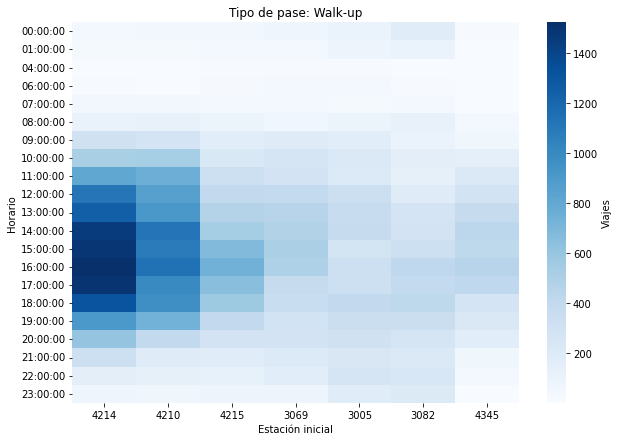

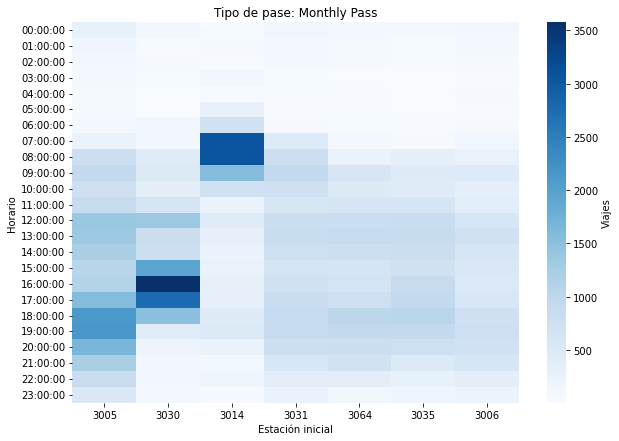

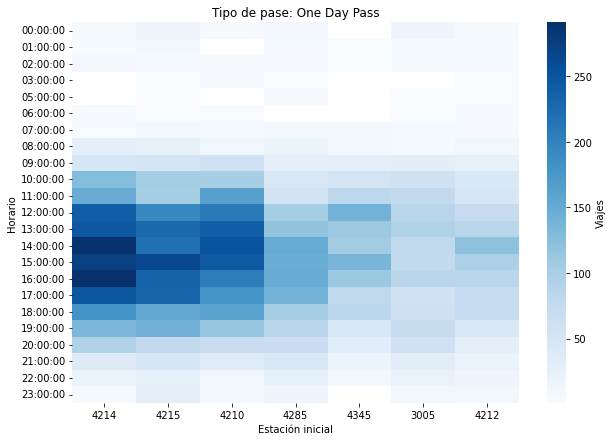

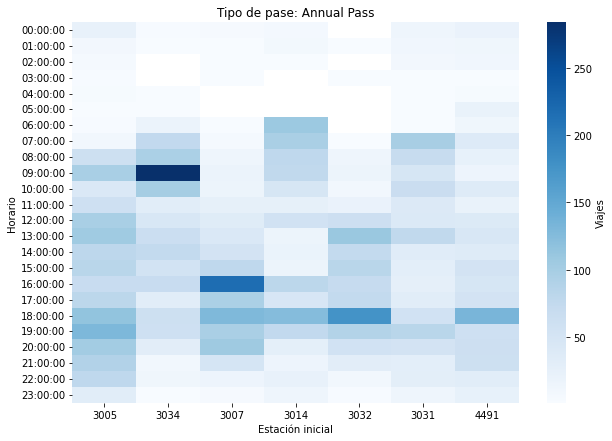

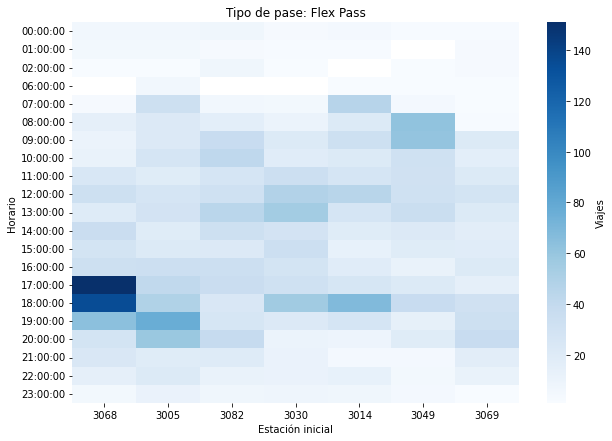

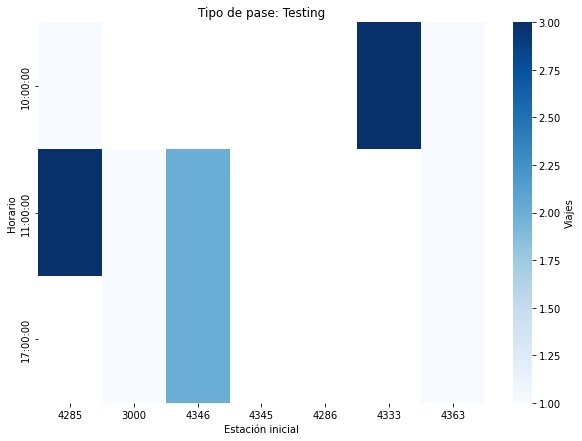

In [24]:
for h in range(0,len(hm)):
    fig = plt.figure(figsize =(10, 7))
    sns.heatmap(hm[h], cmap="Blues", cbar_kws={'label': 'Viajes'})
    plt.xlabel('Estación inicial')
    plt.ylabel('Horario')
    plt.title("Tipo de pase: " +passholderTypes[h])
    plt.show()


### Inspeccionando valores nulos o faltantes

In [25]:
df = pd.read_csv("./ds-programming-test/train_set.csv")

C:\Users\Rafa\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


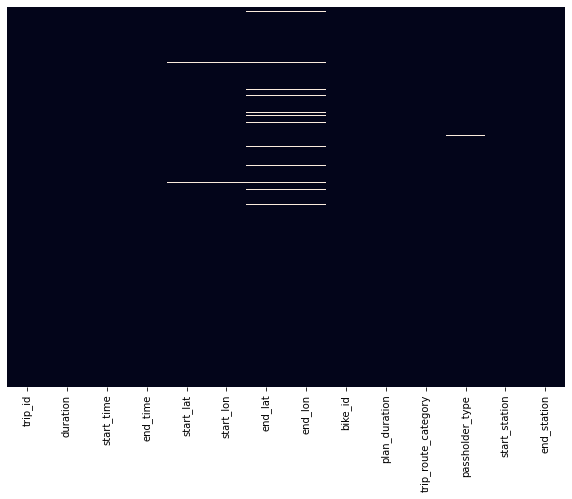

In [26]:
fig = plt.figure(figsize =(10, 7))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)
plt.show()

In [27]:
nullValues = df.isna().any(axis=1).sum()
print("# Filas con valores nulos: {}".format(nullValues))
print("% de filas con valores nulos: {}".format((nullValues*100)/len(df)))

# Filas con valores nulos: 24374
% de filas con valores nulos: 3.482


In [28]:
df = df.dropna()

### Visualizando la distribución de las clases

In [29]:
df["passholder_type"].value_counts()

Monthly Pass    387435
Walk-up         203867
One Day Pass     39888
Annual Pass      32973
Flex Pass        11420
Testing             43
Name: passholder_type, dtype: int64

### Conversión númerica de clases y objetos categóricos

In [35]:
X = df.copy()
X['passholder_type'] = X['passholder_type'].factorize()[0]
X['trip_route_category'] = X['trip_route_category'].factorize()[0]

### Búsqueda de variables con mayor correlación

In [36]:
corr_matrix = X.corr()
corr_matrix["passholder_type"].sort_values(ascending=False)

passholder_type        1.000000
plan_duration          0.718197
trip_route_category    0.168115
trip_id                0.068585
start_lat              0.021973
end_lat                0.021160
start_lon              0.006718
end_lon                0.005484
duration              -0.090050
start_station         -0.098215
end_station           -0.099066
Name: passholder_type, dtype: float64

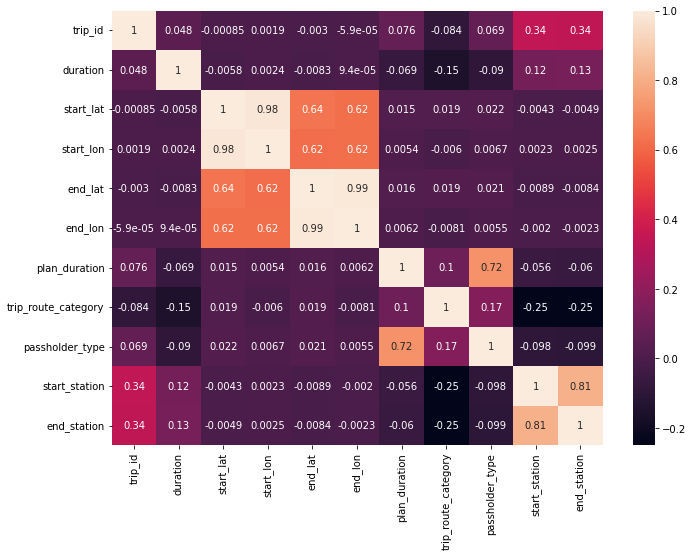

In [37]:
fig = plt.figure(figsize =(11, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

array([[<AxesSubplot:title={'center':'trip_id'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'start_lat'}>],
       [<AxesSubplot:title={'center':'start_lon'}>,
        <AxesSubplot:title={'center':'end_lat'}>,
        <AxesSubplot:title={'center':'end_lon'}>],
       [<AxesSubplot:title={'center':'plan_duration'}>,
        <AxesSubplot:title={'center':'trip_route_category'}>,
        <AxesSubplot:title={'center':'passholder_type'}>],
       [<AxesSubplot:title={'center':'start_station'}>,
        <AxesSubplot:title={'center':'end_station'}>, <AxesSubplot:>]],
      dtype=object)

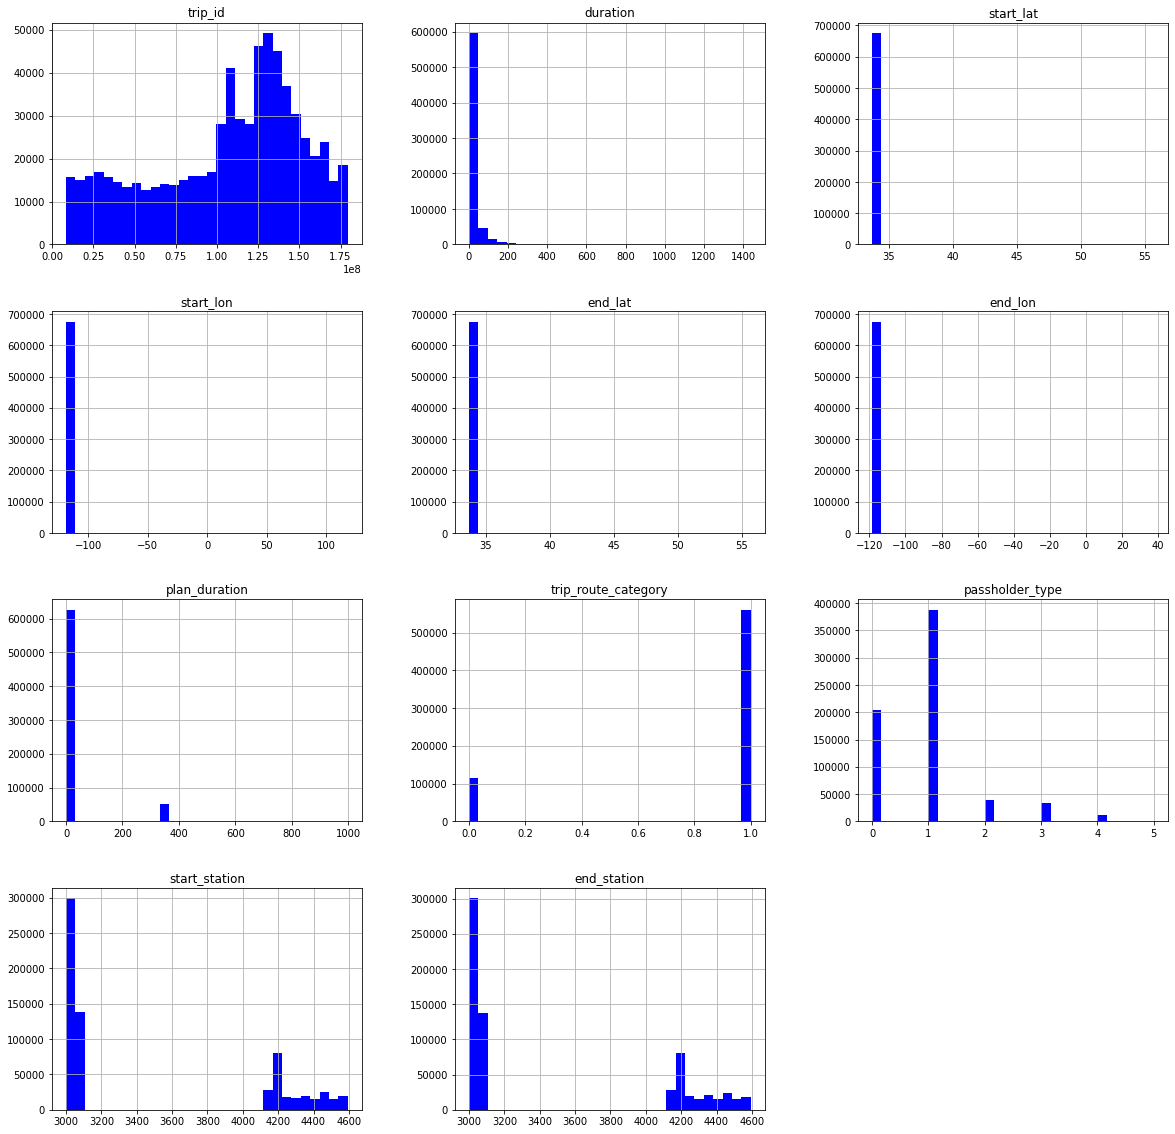

In [38]:
X.hist(bins=30, figsize =(20,20),color='b')

In [39]:
X['passholder_type'] = df["passholder_type"]
y = X["passholder_type"]
X.drop(["start_time", "end_time","bike_id", "plan_duration"], axis=1, inplace=True)

In [40]:
train_set, val_set, test_set = train_val_test_split(X)

In [41]:
X_train, y_train = remove_labels(train_set, 'passholder_type')
X_val, y_val = remove_labels(val_set, 'passholder_type')
X_test, y_test = remove_labels(test_set, 'passholder_type')

### Árbol de decisión

In [42]:
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [43]:
y_train_pred = clf_tree.predict(X_val)

In [44]:
print("F1 Score Train Set:", f1_score(y_train_pred, y_val, average='weighted'))

F1 Score Train Set: 0.6584083834390587


### Random Forest

In [45]:
clf_rnd = RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [46]:
y_pred = clf_rnd.predict(X_val)

In [47]:
print("F1 Score:", f1_score(y_pred, y_val, average='weighted'))

F1 Score: 0.7438844808684347


### Seleccionando los mejores hiperparámetros Random Forest

In [48]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_depth': randint(low=8, high=50),
    }

rnd_clf = RandomForestClassifier(n_jobs=-1)
rnd_search = RandomizedSearchCV(rnd_clf, param_distributions=param_distribs,
                                n_iter=6, cv=4, scoring='f1_weighted')

rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1), n_iter=6,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021C6CF672E0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021C6F518310>},
                   scoring='f1_weighted')

In [49]:
rnd_search.best_params_

{'max_depth': 25, 'n_estimators': 72}

In [50]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("F1 score:", mean_score, "-", "Parámetros:", params)

F1 score: 0.713215070879802 - Parámetros: {'max_depth': 29, 'n_estimators': 30}
F1 score: 0.6813209797565606 - Parámetros: {'max_depth': 15, 'n_estimators': 172}
F1 score: 0.7149080372240901 - Parámetros: {'max_depth': 49, 'n_estimators': 163}
F1 score: 0.7151138150604398 - Parámetros: {'max_depth': 42, 'n_estimators': 157}
F1 score: 0.6952812149232971 - Parámetros: {'max_depth': 17, 'n_estimators': 53}
F1 score: 0.7177248796407601 - Parámetros: {'max_depth': 25, 'n_estimators': 72}


In [51]:
clf_rnd = rnd_search.best_estimator_

In [52]:
y_val_pred = clf_rnd.predict(X_val)

In [53]:
print("F1 score Validation Set:", f1_score(y_val_pred, y_val, average='weighted'))

F1 score Validation Set: 0.757396567760704


C:\Users\Rafa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Annual Pass'),
  Text(1, 0, 'Flex Pass'),
  Text(2, 0, 'Monthly Pass'),
  Text(3, 0, 'One Day Pass'),
  Text(4, 0, 'Testing'),
  Text(5, 0, 'Walk-up')])

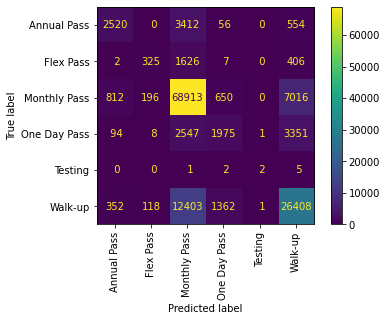

In [54]:
plot_confusion_matrix(clf_rnd, X_val, y_val, values_format='3g')
plt.xticks(rotation=90)

### Prediciendo passholder type de datos Test

In [55]:
test = pd.read_csv("./ds-programming-test/test_set.csv")

C:\Users\Rafa\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [56]:
test.drop(["start_time", "end_time","bike_id"], axis=1, inplace=True)
test['trip_route_category'] = test['trip_route_category'].factorize()[0]

In [57]:
test.head()

,trip_id,duration,start_lat,start_lon,end_lat,end_lon,trip_route_category,start_station,end_station
0,17059130,12,34.058319,-118.246094,34.058319,-118.246094,0,3028,3028
1,17059129,17,34.049980,-118.247162,34.043732,-118.260139,1,3027,3018
2,17059126,20,34.063389,-118.236160,34.044159,-118.251579,1,3066,3055
3,17059125,12,34.048851,-118.246422,34.050140,-118.233238,1,3029,3079
4,17061379,48,34.049198,-118.252831,34.049198,-118.252831,0,3063,3063


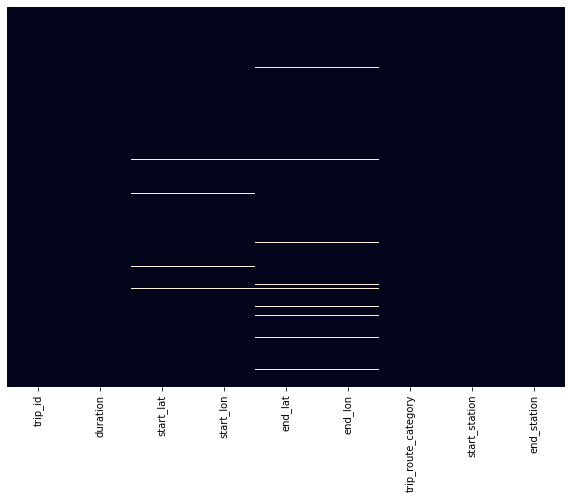

In [58]:
fig = plt.figure(figsize =(10, 7))
sns.heatmap(test.isnull(), yticklabels=False, cbar=False)
plt.show()

In [61]:
for col in test.columns:
    df_nan = test[test[col].isin([np.nan, np.inf, -np.inf])]
    if df_nan.shape[0] != 0:
        print(col)
test[test['start_lat'].isin([np.nan, np.inf, -np.inf])]

start_lat
start_lon
end_lat
end_lon


,trip_id,duration,start_lat,start_lon,end_lat,end_lon,trip_route_category,start_station,end_station
8462,20813352,35,NaN,NaN,34.045181,-118.250237,1,3000,3067
8515,20829213,18,NaN,NaN,34.045540,-118.256668,1,3000,3006
9804,21415209,13,NaN,NaN,34.042110,-118.256187,1,3000,3075
10786,21784504,20,NaN,NaN,34.051102,-118.264557,1,3000,3052
11058,21934003,13,NaN,NaN,34.046810,-118.256981,1,3000,3064
...,...,...,...,...,...,...,...,...,...
549811,169962588,10,NaN,NaN,34.186569,-118.388008,1,4286,4499
551410,172788071,346,NaN,NaN,34.168331,-118.396156,1,4285,4415
561729,176310860,27,NaN,NaN,NaN,NaN,0,3000,3000
562066,176444433,27,NaN,NaN,34.032860,-118.268082,1,3000,3025


In [62]:
test['end_lon'].fillna(value =round(test["end_lon"].mean(),6) , inplace = True)
test['end_lat'].fillna(value =round(test["end_lat"].mean(),6) , inplace = True) 
test['start_lon'].fillna(value =round(test["start_lon"].mean(),6) , inplace = True)
test['start_lat'].fillna(value =round(test["start_lat"].mean(),6) , inplace = True)

In [63]:
y_val = clf_rnd.predict(test)

In [64]:
results = pd.DataFrame({"trip_id":list(test["trip_id"]),"passholder_type":y_val})
results.to_csv("./ds-programming-test/results.csv", index=None)